# Unit Quality Metrics

## Tutorial overview

This Jupyter notebook will provide a detailed explanation of the unit quality metrics included Allen Institute Neuropixels Visual Coding dataset. It's important to pay attention to quality metrics, because failing to apply them correctly could lead to invalid scientific conclusions, or could end up hiding potentially useful data.

To help you avoid these pitfalls, this tutorial will explore how these metrics are calculated, how they might be biased, and how they can be best applied to specific use cases. Of course, it's important to keep in mind that none of these metrics are perfect, and that the use of quality metrics for filtering ephys data is still an evolving area of research. More work must is required in order to establish general-purpose best practices and standards in this domain.

This tutorial assumes you've already created a data cache, or are working with the files on AWS. If you haven't reached that step yet, we recommend going through the [data access tutorial](URL) first.

Functions related to data analysis will be covered in other tutorials, such as [this](URL), [this](URL), and [this](URL). For a full list of available tutorials, see this [README](URL) file.

## Why do we need quality metrics?

For a long time, converting continuous voltage traces to sorted spike times was one of the "dark arts" of neuroscience. Spikes were typically sorted by hand-drawing boundaries around clouds of dots, using heuristics learned from other lab members. The quality of the resulting clusters could be validated by looking at metrics such as ISI violations or isolation distance, but there were no standards governing how these metrics informed which units to include for further analysis.

Recent in advances in neural recording devices, such as Neuropixels, have made it practically impossible to sort spikes by hand. Fortunately, we now have access to powerful sorting algorithms that use GPUs to extract spikes and associate them with particular units in approximately the same amount of time it took to record the data. All of the Allen Institute Neuropixels data has been sorted with [Kilosort2](https://github.com/MouseLand/Kilosort2), a template-matching algorithm developed by Marius Pachitariu at HHMI Janelia Research Campus.

For Neuropixels recordings with minimal electrode drift, Kilosort2 performs well enough that further manual curation is not necessary. Unlike the original version of Kilosort, which required a manual merging step, Kilosort2 attempts to merge units automatically. Sometimes it over-merges, leading to units that clearly combine spikes from multiple cells. But in the majority of cases, Kilosort2 makes merging decisions as well as a human would, and does it in a way that is reproducible.

One of the inherent trade-offs in any spike sorting algorithm is the threshold that one chooses for calling something a "spike." Choosing a higher threshold reduces the chance that "noise" waveforms will contaminate the outputs, while increasing the probability that true spikes will be missed.

What mistakes are made?

* Adding spikes

From another cluster

* Missing spikes

Assigned to another cluster
Below threshold
Not included
Drift out of recording

How do we estimate these? How do we use this information to decide what to include for further analysis.

Key thing: for a dataset that's meant for data mining, we don't want to exclude potentially valuable information. All units contain information about brain state.

As an example, say you want to decode a stimulus from a brain state; you don't care what the units are doing, you just want all the information available. In this case, using all the units is preferable. 

Another extreme-- you're looking at bursting. Here, it's important that you have every spike, because missing spikes are dangerous, and contaminating spikes will skew your estimates of burst rate. So you can tolerate fewer units, by setting a more conservative threshold.

We are leaving it up to the end-users to be responsible for using these metrics. Default values filter out units that are highly contaminated or missing lots of spikes, but you will likely need to adjust these threshold for your analysis.

Available metrics:
* <a href='#Firing-rate'>Firing rate</a>
* ISI violations
* Isolation distance
* etc.

## How these metrics were calculated

The Python code used to calculate these metrics from the outputs of Kilosort2 is available in the [ecephys_spike_sorting](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/quality_metrics) repository. This code was recently incorporated into the [SpikeMetrics](https://github.com/SpikeInterface/spikemetrics) repository by the SpikeInterface team. It's now available as a PyPi package (`pip install spikemetrics`) if you'd like to try them out on your own data.

If you have any questions about the specific implementation of these metrics, or recommendations for new ones to include, we encourage you to submit an issue in either repository.

## Accessing the metrics

Because these metrics are so important to interpreting your results, they are included in every DataFrame that stores information about individual units.

To take a look at the metrics for all units in the dataset, simply call `get_units()` on the `EcephysProjectCache` object.

In [7]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

data_directory = '/mnt/nvme0/ecephys_cache_dir_10_31'

manifest_path = os.path.join(data_directory, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

units = cache.get_units()

In [3]:
len(units)

40010

By default, the AllenSDK applies filters so only units above a particular quality threshold are returned.

The default filter values are as follows:

- `isi_violations` < 0.5
- `amplitude_cutoff` < 0.1
- `presence_ratio` > 0.9

Let's disable these filters so we can see all of the available units:

In [8]:
units = cache.get_units(amplitude_cutoff_maximum = np.inf,
                        presence_ratio_minimum = -np.inf,
                        isi_violations_maximum = np.inf)

len(units)

99180

Now we have a DataFrame that contains all of the units detected by Kilosort2 across 58 experiments. Importantly, this does not include units with invalid waveforms. Kilosort2 often detects "spikes" that are very clearly not associated with action potentials; they can result from electrical artifacts, or lower-frequency voltage fluctuations that cross the spike detection threshold. The majority of these "noise" units are automatically filtered out via [this module](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/noise_templates), followed by a manual inspection step to identify any remaining artifactual waveforms.

Let's look in more detail at the distribution of some quality metrics across 99,180 units. We'll start by creating a function for plotting each metric in an aesthetically pleasing way:

In [57]:
from scipy.ndimage.filters import gaussian_filter1d
plt.rcParams.update({'font.size': 14})

def plot_metric(data, bins, x_axis_label, color, max_value=-1):
    
    h, b = np.histogram(data, bins=bins, density=True)

    x = b[:-1]
    y = gaussian_filter1d(h, 1)

    plt.plot(x, y, color=color)
    plt.xlabel(x_axis_label)
    plt.gca().get_yaxis().set_visible(False)
    [plt.gca().spines[loc].set_visible(False) for loc in ['right', 'top', 'left']]
    if max_value < np.max(y) * 1.1:
        max_value = np.max(y) * 1.1
    plt.ylim([0, max_value])
    
    return max_value

## Firing rate

First, let's take a look at firing rate, which is the most straightforward metric to compute. Firing rate is equal to the total number of spikes divided by the number of seconds in the recording. We'll create a density plot of firing rate across all units in the dataset:

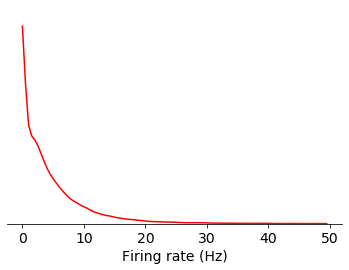

In [58]:
data = units['firing_rate']
bins = np.linspace(0,50,100)

max_value = plot_metric(data, bins, 'Firing rate (Hz)', 'red')

Since there are many units with low firing rates, let's use a log scale instead:

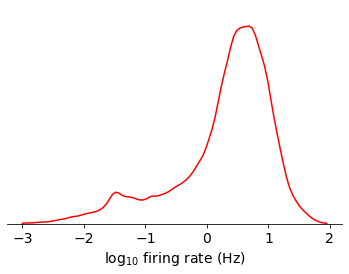

In [59]:
data = np.log10(units['firing_rate'])
bins = np.linspace(-3,2,100)

max_value = plot_metric(data, bins, 'log$_{10}$ firing rate (Hz)', 'red')

Based on this plot, a log scale seems more appropriate for firing rate. You can clearly see the approximately lognormal distribution of firing rates, which [has been described previously](http://www.buzsakilab.com/content/PDFs/Mizuseki2014.pdf). However, there's more weight on the lower tail of the distribution, which is likely due to some units missing spikes as a result of thresholding or drift. If we filter out contaminated units using another metric, `nn_hit_rate` (more on what this means later), the distribution becomes almost perfectly lognormal:

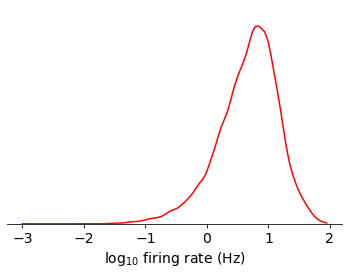

In [60]:
data = np.log10(units[units.nn_hit_rate > 0.9]['firing_rate'])
bins = np.linspace(-3,2,100)

max_value = plot_metric(data, bins, 'log$_{10}$ firing rate (Hz)', 'red')

Before we move on to the next metric, let's add one more feature to these plots. Displaying the metrics separately for different brain regions can be helpful for understanding the variation that results from physiological features of the area we're recording from. The four main regions that are part of the Neuropixels Visual Coding dataset are cortex, thalamus, hippocampus, and midbrain. We'll use the Allen CCF structure acronyms to find the units that belong to each region.

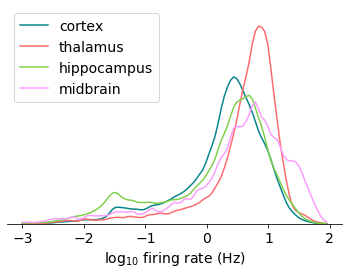

In [61]:
region_dict = {'cortex' : ['VISp', 'VISl', 'VISrl', 'VISam', 'VISpm', 'VIS', 'VISal','VISmma','VISmmp','VISli'],
             'thalamus' : ['LGd','LD', 'LP', 'VPM', 'TH', 'MGm','MGv','MGd','PO','LGv','VL',
              'VPL','POL','Eth','PoT','PP','PIL','IntG','IGL','SGN','VPL','PF','RT'],
             'hippocampus' : ['CA1', 'CA2','CA3', 'DG', 'SUB', 'POST','PRE','ProS','HPF'],
             'midbrain': ['MB','SCig','SCiw','SCsg','SCzo','PPT','APN','NOT','MRN','OP','LT','RPF','CP']}

color_dict = {'cortex' : '#08858C',
              'thalamus' : '#FC6B6F',
              'hippocampus' : '#7ED04B',
              'midbrain' : '#FC9DFE'}

bins = np.linspace(-3,2,100)
max_value = -np.inf

for idx, region in enumerate(region_dict.keys()):
    
    data = np.log10(units[units.ecephys_structure_acronym.isin(region_dict[region])]['firing_rate'])
    
    max_value = plot_metric(data, bins, 'log$_{10}$ firing rate (Hz)', color_dict[region], max_value)
    
_ = plt.legend(region_dict.keys())

We can see a clear separation in the distributions across areas; the thalamus has a lot of units that fire in the 8 Hz range (remember the log scale), while the midbrain has the most units with very high rates (>20 Hz).

Here's a summary of things to keep in mind when using `firing_rate` in your analysis:

**How it can be biased**
* If a unit is poorly isolated, the firing rate will be over-estimated, because contaminating spikes will be included in the calculation
* If a unit's amplitude is close to threshold, the firing rate will be under-estimated, because some spikes will be missing
* If a unit drifts out of the recording, the firing rate will be under-estimated, because spikes will not be detected for a portion of the recording
* If data acquisition is interrupted (true for a small subset of experiments, see more [here](URL)), the firing rate will be under-estimated, because spikes will be missing from gaps in the recording

**How it should be used**
* Firing rate can be used to filter out units that have too few spikes to result in meaningful analysis. In this case, it may be better to use the firing rate for the specific interval you're analyzing, because some units may drift out of the recording at other times.
* High firing rate units tend to be easier to isolate, since there are more spikes available for fitting the template in Kilosort2. However, there are other metrics that measure isolation more directly and would likely to be better to use instead.

## ISI violations